In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os , pickle
from sklearn.model_selection import train_test_split , cross_val_predict 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import (accuracy_score , classification_report,
                            confusion_matrix , ConfusionMatrixDisplay
                            )
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder  , FunctionTransformer
from sklearn.pipeline import Pipeline , make_pipeline 
from sklearn.compose import ColumnTransformer

In [2]:
data = pd.read_csv("../data/preb_churn_data.csv")
data.head()

,Customerid,Gender,Senior_citizen,Is_married,Dependents,Tenure,Phone_service,Dual,Internet_service,Online_security,...,Device_protection,Tech_support,Streaming_tv,Streaming_movies,Contract,Paperless_billing,Payment_method,Monthly_charges,Total_charges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data['Customerid'].is_unique

True

In [4]:
data.drop(columns='Customerid' , inplace=True)

In [5]:
data['Churn'].value_counts(normalize=True)

No     0.734215
Yes    0.265785
Name: Churn, dtype: float64

In [6]:
data['Churn'] = data['Churn'].apply(lambda x : 0 if x == 'No' else 1).astype(int)

In [7]:
#data is not implanced 

In [8]:
#split data 
X = data.drop(columns='Churn')
y = data['Churn']
X_train, X_valid, y_train, y_valid = train_test_split(X , y , test_size=0.2 , shuffle=True , random_state=42 , 
                                                    stratify=y)

X_valid , X_test , y_valid , y_test = train_test_split(X_valid , y_valid , test_size=0.5 , 
                                                       random_state=42 , stratify=y_valid)

print('X train shape ', X_train.shape)
print('X valid shape ', X_valid.shape)
print('X test shape ' , X_test.shape)


X train shape  (5625, 19)
X valid shape  (703, 19)
X test shape  (704, 19)


In [9]:
#get categorical columns 
categorical_columns = X_train.select_dtypes(exclude='number').columns.values
categorical_columns


array(['Gender', 'Is_married', 'Dependents', 'Phone_service', 'Dual',
       'Internet_service', 'Online_security', 'Online_backup',
       'Device_protection', 'Tech_support', 'Streaming_tv',
       'Streaming_movies', 'Contract', 'Paperless_billing',
       'Payment_method'], dtype=object)

In [10]:
numerical_columns = X_train.select_dtypes(include='number').columns.values
assert len(categorical_columns) + len(numerical_columns) == len(X_train.columns.values)

In [11]:
def label_encode(X):
    X = X.copy()
    label_encoder = LabelEncoder()
    
    for col in X.columns:
        X[col] = label_encoder.fit_transform(X[col])
    return X

In [12]:
#build pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', FunctionTransformer(label_encode), categorical_columns),
        ('num', 'passthrough', numerical_columns)
    ]
)

In [21]:
#Random forest 
random_forest_pipeline = Pipeline(steps=[('preprocessor' , preprocessor) , 
                                         ('model' , RandomForestClassifier(random_state=42 , class_weight='balanced'))])


In [14]:
random_forest_grid_search = GridSearchCV(estimator=random_forest_pipeline , 
                                         param_grid={'model__n_estimators':[20, 50 , 100 , 120] , 
                                                     'model__max_depth':[None , 5, 10 , 15]} , 
                                         cv=3, scoring= 'f1' ).fit(X_train , y_train)

In [15]:
random_forest_grid_search.best_score_

0.6288826050705616

In [16]:
def plot_confusion_metricss(y_pred , y_true , ax , split):
    cm = confusion_matrix(y_true , y_pred , normalize='true')
    disp = ConfusionMatrixDisplay(cm , display_labels=['No' , 'Yes'])
    disp.plot(cmap='Blues' , values_format='.2f' , ax = ax , colorbar=False)
    ax.set_title(f"Normalized Confusion Metrics for {split}")

In [34]:
def get_metrics_reports(model):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    y_test_pred = model.predict(X_test)
    
    print('According to train data ......')
    
    print(classification_report(y_train , y_train_pred , labels=[0,1]))
    
    print(f"Train Acuuracy {accuracy_score(y_train , y_train_pred)*100:0.2f}%")
    
    print("According to validation data .....")
    
    print(classification_report(y_valid , y_valid_pred , labels=[0,1]))
    
    print(f"Valid Acuuracy {accuracy_score(y_valid, y_valid_pred)*100:0.2f}%")
    
    print("According to testing data .....")
    
    print(classification_report(y_test , y_test_pred , labels=[0,1]))
    
    print(f"Test Acuuracy {accuracy_score(y_test, y_test_pred)*100:0.2f}%")
    
    fig , (ax1 , ax2, ax3) = plt.subplots(3, 1 , figsize = (8, 15) , sharey=True)
    
    plot_confusion_metricss(y_train_pred , y_train , ax1 , split='Train')
    
    plot_confusion_metricss(y_valid_pred , y_valid , ax2 , split='Valid')
    
    plot_confusion_metricss(y_test_pred , y_test , ax3 , split='Test')
    
    plt.show()

In [35]:
best_random_forest_model = random_forest_grid_search.best_estimator_
best_random_forest_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  FunctionTransformer(func=<function label_encode at 0x00000250D336BD90>),
                                                  array(['Gender', 'Is_married', 'Dependents', 'Phone_service', 'Dual',
       'Internet_service', 'Online_security', 'Online_backup',
       'Device_protection', 'Tech_support', 'Streaming_tv',
       'Streaming_movies', 'Contract', 'Paperless_billing',
       'Payment_method'], dtype=object)),
                                                 ('num', 'passthrough',
                                                  array(['Senior_citizen', 'Tenure', 'Monthly_charges', 'Total_charges'],
      dtype=object))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        random_state=42))])

According to train data ......
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      4130
           1       0.53      0.82      0.64      1495

    accuracy                           0.76      5625
   macro avg       0.72      0.78      0.73      5625
weighted avg       0.82      0.76      0.77      5625

Train Acuuracy 75.88%
According to validation data .....
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       516
           1       0.46      0.76      0.58       187

    accuracy                           0.70       703
   macro avg       0.67      0.72      0.67       703
weighted avg       0.77      0.70      0.72       703

Valid Acuuracy 69.99%
According to testing data .....
              precision    recall  f1-score   support

           0       0.93      0.73      0.81       517
           1       0.53      0.84      0.65       187

    accuracy                           0

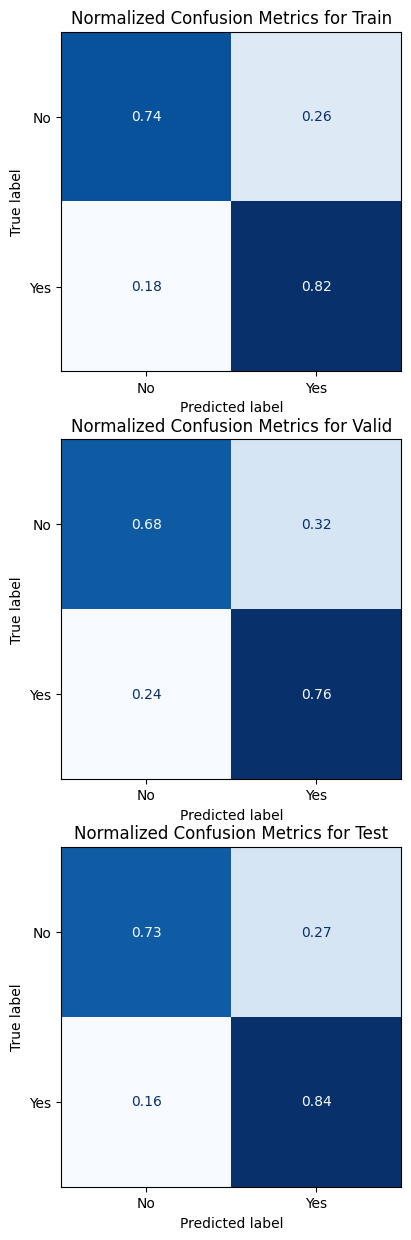

In [36]:
get_metrics_reports(best_random_forest_model)

In [22]:
#now store model we can enhance it by using diffrent techniques and algorithms such xgboost , using smote techniques

In [44]:
X_train.iloc[0, :].values

array(['Male', 0, 'Yes', 'Yes', 65, 'Yes', 'Yes', 'Fiber optic', 'Yes',
       'Yes', 'Yes', 'Yes', 'No', 'No', 'Two year', 'No',
       'Credit card (automatic)', 94.55, 6078.75], dtype=object)

In [37]:
with open('../models/model_pipeline.pkl', 'wb') as file:
    pickle.dump(best_random_forest_model, file)